<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[15:19:34] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


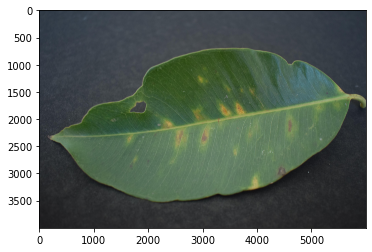

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

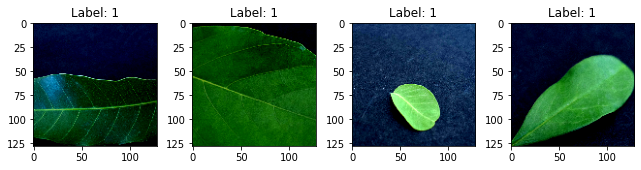

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[15:19:39] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[15:19:41] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2182943822298762 samples/sec                   batch loss = 0.7073132991790771 | accuracy = 0.6


Epoch[1] Batch[10] Speed: 1.2750696502674215 samples/sec                   batch loss = 3.0055999755859375 | accuracy = 0.575


Epoch[1] Batch[15] Speed: 1.2813643433208761 samples/sec                   batch loss = 0.445887953042984 | accuracy = 0.65


Epoch[1] Batch[20] Speed: 1.2783772551901358 samples/sec                   batch loss = 1.057106614112854 | accuracy = 0.6375


Epoch[1] Batch[25] Speed: 1.2642169641761831 samples/sec                   batch loss = 0.5498825907707214 | accuracy = 0.61


Epoch[1] Batch[30] Speed: 1.2711360295788947 samples/sec                   batch loss = 0.5878307819366455 | accuracy = 0.625


Epoch[1] Batch[35] Speed: 1.273089561232528 samples/sec                   batch loss = 0.9681488275527954 | accuracy = 0.6428571428571429


Epoch[1] Batch[40] Speed: 1.2719513212141798 samples/sec                   batch loss = 0.8461467623710632 | accuracy = 0.63125


Epoch[1] Batch[45] Speed: 1.273698654992448 samples/sec                   batch loss = 0.28794416785240173 | accuracy = 0.6277777777777778


Epoch[1] Batch[50] Speed: 1.2669251683296496 samples/sec                   batch loss = 0.4067610502243042 | accuracy = 0.63


Epoch[1] Batch[55] Speed: 1.2737512603916592 samples/sec                   batch loss = 0.42602163553237915 | accuracy = 0.6181818181818182


Epoch[1] Batch[60] Speed: 1.2761587302867126 samples/sec                   batch loss = 0.6289662718772888 | accuracy = 0.6041666666666666


Epoch[1] Batch[65] Speed: 1.2756571675012025 samples/sec                   batch loss = 1.0271230936050415 | accuracy = 0.6


Epoch[1] Batch[70] Speed: 1.2686568879688382 samples/sec                   batch loss = 0.3976331949234009 | accuracy = 0.6


Epoch[1] Batch[75] Speed: 1.2698659327369524 samples/sec                   batch loss = 0.4273504614830017 | accuracy = 0.6033333333333334


Epoch[1] Batch[80] Speed: 1.2727510519766114 samples/sec                   batch loss = 0.6347714066505432 | accuracy = 0.6


Epoch[1] Batch[85] Speed: 1.2777280631835513 samples/sec                   batch loss = 0.8399019241333008 | accuracy = 0.6


Epoch[1] Batch[90] Speed: 1.2740379588104587 samples/sec                   batch loss = 1.245881199836731 | accuracy = 0.5972222222222222


Epoch[1] Batch[95] Speed: 1.2675456139043968 samples/sec                   batch loss = 0.3696601092815399 | accuracy = 0.6026315789473684


Epoch[1] Batch[100] Speed: 1.2759351178956628 samples/sec                   batch loss = 0.8707307577133179 | accuracy = 0.6


Epoch[1] Batch[105] Speed: 1.2654966850251965 samples/sec                   batch loss = 0.3235541880130768 | accuracy = 0.6047619047619047


Epoch[1] Batch[110] Speed: 1.2718147881872313 samples/sec                   batch loss = 0.6492074131965637 | accuracy = 0.6136363636363636


Epoch[1] Batch[115] Speed: 1.2676492402211605 samples/sec                   batch loss = 0.5760454535484314 | accuracy = 0.6217391304347826


Epoch[1] Batch[120] Speed: 1.2650360877869604 samples/sec                   batch loss = 0.8775654435157776 | accuracy = 0.6208333333333333


Epoch[1] Batch[125] Speed: 1.2731006708638912 samples/sec                   batch loss = 0.40470728278160095 | accuracy = 0.624


Epoch[1] Batch[130] Speed: 1.2713567104256198 samples/sec                   batch loss = 1.0035566091537476 | accuracy = 0.6211538461538462


Epoch[1] Batch[135] Speed: 1.2712008484362733 samples/sec                   batch loss = 0.2615019977092743 | accuracy = 0.6259259259259259


Epoch[1] Batch[140] Speed: 1.2717552088078887 samples/sec                   batch loss = 0.2748014032840729 | accuracy = 0.6321428571428571


Epoch[1] Batch[145] Speed: 1.2734283472567145 samples/sec                   batch loss = 0.32060477137565613 | accuracy = 0.6344827586206897


Epoch[1] Batch[150] Speed: 1.2716927432205178 samples/sec                   batch loss = 0.5124074816703796 | accuracy = 0.6383333333333333


Epoch[1] Batch[155] Speed: 1.2687760480672154 samples/sec                   batch loss = 0.20462915301322937 | accuracy = 0.6419354838709678


Epoch[1] Batch[160] Speed: 1.2752639751800658 samples/sec                   batch loss = 0.7369820475578308 | accuracy = 0.6421875


Epoch[1] Batch[165] Speed: 1.2662277254489553 samples/sec                   batch loss = 0.4562358260154724 | accuracy = 0.6393939393939394


Epoch[1] Batch[170] Speed: 1.2662368998584568 samples/sec                   batch loss = 0.49934059381484985 | accuracy = 0.638235294117647


Epoch[1] Batch[175] Speed: 1.2733097613035997 samples/sec                   batch loss = 0.5322312116622925 | accuracy = 0.6428571428571429


Epoch[1] Batch[180] Speed: 1.2693744894799968 samples/sec                   batch loss = 1.446181297302246 | accuracy = 0.6430555555555556


Epoch[1] Batch[185] Speed: 1.2576807532044134 samples/sec                   batch loss = 0.30781319737434387 | accuracy = 0.6486486486486487


Epoch[1] Batch[190] Speed: 1.2660624177262454 samples/sec                   batch loss = 0.6829655170440674 | accuracy = 0.6486842105263158


Epoch[1] Batch[195] Speed: 1.268719919145385 samples/sec                   batch loss = 0.9874218702316284 | accuracy = 0.6474358974358975


Epoch[1] Batch[200] Speed: 1.2731610526858177 samples/sec                   batch loss = 0.9441338181495667 | accuracy = 0.65125


Epoch[1] Batch[205] Speed: 1.2688341971106316 samples/sec                   batch loss = 0.34907984733581543 | accuracy = 0.651219512195122


Epoch[1] Batch[210] Speed: 1.2663436577092329 samples/sec                   batch loss = 0.6853544116020203 | accuracy = 0.65


Epoch[1] Batch[215] Speed: 1.2650600301975752 samples/sec                   batch loss = 0.47184479236602783 | accuracy = 0.6511627906976745


Epoch[1] Batch[220] Speed: 1.2715186816937925 samples/sec                   batch loss = 0.5676934123039246 | accuracy = 0.65


Epoch[1] Batch[225] Speed: 1.2670285975328717 samples/sec                   batch loss = 0.7758643627166748 | accuracy = 0.65


Epoch[1] Batch[230] Speed: 1.2600268554927698 samples/sec                   batch loss = 0.8180877566337585 | accuracy = 0.6478260869565218


Epoch[1] Batch[235] Speed: 1.2674902640896837 samples/sec                   batch loss = 0.6505755186080933 | accuracy = 0.6478723404255319


Epoch[1] Batch[240] Speed: 1.2728891381474736 samples/sec                   batch loss = 0.7179737091064453 | accuracy = 0.6447916666666667


Epoch[1] Batch[245] Speed: 1.27473667342916 samples/sec                   batch loss = 0.38259124755859375 | accuracy = 0.6479591836734694


Epoch[1] Batch[250] Speed: 1.2739495366967082 samples/sec                   batch loss = 0.6340570449829102 | accuracy = 0.651


Epoch[1] Batch[255] Speed: 1.267431376428467 samples/sec                   batch loss = 0.7696431875228882 | accuracy = 0.6519607843137255


Epoch[1] Batch[260] Speed: 1.272813814703697 samples/sec                   batch loss = 0.32247763872146606 | accuracy = 0.6528846153846154


Epoch[1] Batch[265] Speed: 1.2793542322082299 samples/sec                   batch loss = 1.2139064073562622 | accuracy = 0.6518867924528302


Epoch[1] Batch[270] Speed: 1.276641161312267 samples/sec                   batch loss = 0.4328001141548157 | accuracy = 0.6537037037037037


Epoch[1] Batch[275] Speed: 1.2791138950983054 samples/sec                   batch loss = 0.547884464263916 | accuracy = 0.6536363636363637


Epoch[1] Batch[280] Speed: 1.2713980424193005 samples/sec                   batch loss = 0.39083293080329895 | accuracy = 0.6544642857142857


Epoch[1] Batch[285] Speed: 1.2761892113081825 samples/sec                   batch loss = 0.38306787610054016 | accuracy = 0.6552631578947369


Epoch[1] Batch[290] Speed: 1.2758058777263375 samples/sec                   batch loss = 0.7672208547592163 | accuracy = 0.6560344827586206


Epoch[1] Batch[295] Speed: 1.2739142293256034 samples/sec                   batch loss = 0.2635367512702942 | accuracy = 0.6559322033898305


Epoch[1] Batch[300] Speed: 1.2693389550623329 samples/sec                   batch loss = 0.4285680651664734 | accuracy = 0.6575


Epoch[1] Batch[305] Speed: 1.2638978191282073 samples/sec                   batch loss = 0.6275531649589539 | accuracy = 0.660655737704918


Epoch[1] Batch[310] Speed: 1.2733632043984617 samples/sec                   batch loss = 0.48794281482696533 | accuracy = 0.6596774193548387


Epoch[1] Batch[315] Speed: 1.269310817056588 samples/sec                   batch loss = 0.2536869943141937 | accuracy = 0.6603174603174603


Epoch[1] Batch[320] Speed: 1.2780392386588904 samples/sec                   batch loss = 0.941426694393158 | accuracy = 0.65625


Epoch[1] Batch[325] Speed: 1.2719375315904897 samples/sec                   batch loss = 0.6348756551742554 | accuracy = 0.6576923076923077


Epoch[1] Batch[330] Speed: 1.2628326936453393 samples/sec                   batch loss = 0.764068067073822 | accuracy = 0.6575757575757576


Epoch[1] Batch[335] Speed: 1.2692822961873753 samples/sec                   batch loss = 0.5478146076202393 | accuracy = 0.6574626865671642


Epoch[1] Batch[340] Speed: 1.2719590358193973 samples/sec                   batch loss = 1.77352774143219 | accuracy = 0.6558823529411765


Epoch[1] Batch[345] Speed: 1.2774399935675782 samples/sec                   batch loss = 0.5244123935699463 | accuracy = 0.6565217391304348


Epoch[1] Batch[350] Speed: 1.265683901457928 samples/sec                   batch loss = 0.49101319909095764 | accuracy = 0.6564285714285715


Epoch[1] Batch[355] Speed: 1.2724000810588125 samples/sec                   batch loss = 0.3866627514362335 | accuracy = 0.6591549295774648


Epoch[1] Batch[360] Speed: 1.2715028778020905 samples/sec                   batch loss = 0.6077330112457275 | accuracy = 0.6576388888888889


Epoch[1] Batch[365] Speed: 1.2755561070197334 samples/sec                   batch loss = 0.523936927318573 | accuracy = 0.660958904109589


Epoch[1] Batch[370] Speed: 1.268534585061003 samples/sec                   batch loss = 2.351033926010132 | accuracy = 0.6608108108108108


Epoch[1] Batch[375] Speed: 1.2745228539433238 samples/sec                   batch loss = 0.4182986617088318 | accuracy = 0.662


Epoch[1] Batch[380] Speed: 1.272855048356413 samples/sec                   batch loss = 0.6527899503707886 | accuracy = 0.6631578947368421


Epoch[1] Batch[385] Speed: 1.2735019067745148 samples/sec                   batch loss = 0.3016163110733032 | accuracy = 0.6636363636363637


Epoch[1] Batch[390] Speed: 1.277048034564877 samples/sec                   batch loss = 1.2003743648529053 | accuracy = 0.6615384615384615


Epoch[1] Batch[395] Speed: 1.2679375100845345 samples/sec                   batch loss = 0.27855783700942993 | accuracy = 0.660126582278481


Epoch[1] Batch[400] Speed: 1.2741480682707345 samples/sec                   batch loss = 0.711284875869751 | accuracy = 0.66125


Epoch[1] Batch[405] Speed: 1.2768976740699192 samples/sec                   batch loss = 0.2447093427181244 | accuracy = 0.6617283950617284


Epoch[1] Batch[410] Speed: 1.2767018794526468 samples/sec                   batch loss = 0.5283020734786987 | accuracy = 0.6603658536585366


Epoch[1] Batch[415] Speed: 1.2727811773131212 samples/sec                   batch loss = 0.20903380215168 | accuracy = 0.6632530120481928


Epoch[1] Batch[420] Speed: 1.2675638095358979 samples/sec                   batch loss = 0.4413222670555115 | accuracy = 0.6625


Epoch[1] Batch[425] Speed: 1.2743685378964613 samples/sec                   batch loss = 0.9654219150543213 | accuracy = 0.6623529411764706


Epoch[1] Batch[430] Speed: 1.2692503197672242 samples/sec                   batch loss = 0.7249833345413208 | accuracy = 0.6622093023255814


Epoch[1] Batch[435] Speed: 1.271170797861745 samples/sec                   batch loss = 0.8569068908691406 | accuracy = 0.6637931034482759


Epoch[1] Batch[440] Speed: 1.2692946838822077 samples/sec                   batch loss = 0.25416111946105957 | accuracy = 0.6659090909090909


Epoch[1] Batch[445] Speed: 1.271892789695686 samples/sec                   batch loss = 0.5939536690711975 | accuracy = 0.6646067415730337


Epoch[1] Batch[450] Speed: 1.27640650357145 samples/sec                   batch loss = 0.6163179874420166 | accuracy = 0.6633333333333333


Epoch[1] Batch[455] Speed: 1.2753675100869957 samples/sec                   batch loss = 0.6486204862594604 | accuracy = 0.6637362637362637


Epoch[1] Batch[460] Speed: 1.2727628315858388 samples/sec                   batch loss = 0.7216322422027588 | accuracy = 0.6641304347826087


Epoch[1] Batch[465] Speed: 1.262062843255498 samples/sec                   batch loss = 0.5900208950042725 | accuracy = 0.6650537634408602


Epoch[1] Batch[470] Speed: 1.2707582277449372 samples/sec                   batch loss = 0.35438239574432373 | accuracy = 0.6659574468085107


Epoch[1] Batch[475] Speed: 1.2727038391739374 samples/sec                   batch loss = 0.17695598304271698 | accuracy = 0.6668421052631579


Epoch[1] Batch[480] Speed: 1.2751722813326591 samples/sec                   batch loss = 1.1753357648849487 | accuracy = 0.6666666666666666


Epoch[1] Batch[485] Speed: 1.2657023301387782 samples/sec                   batch loss = 0.3222353458404541 | accuracy = 0.6670103092783505


Epoch[1] Batch[490] Speed: 1.27284973708029 samples/sec                   batch loss = 0.4652089774608612 | accuracy = 0.6683673469387755


Epoch[1] Batch[495] Speed: 1.2703894041331762 samples/sec                   batch loss = 0.952529788017273 | accuracy = 0.6681818181818182


Epoch[1] Batch[500] Speed: 1.2706145410142988 samples/sec                   batch loss = 1.2233840227127075 | accuracy = 0.668


Epoch[1] Batch[505] Speed: 1.2685725683806404 samples/sec                   batch loss = 0.4460836946964264 | accuracy = 0.6688118811881189


Epoch[1] Batch[510] Speed: 1.2604382620465266 samples/sec                   batch loss = 0.4177872836589813 | accuracy = 0.6691176470588235


Epoch[1] Batch[515] Speed: 1.2631859191179904 samples/sec                   batch loss = 0.4138105511665344 | accuracy = 0.670388349514563


Epoch[1] Batch[520] Speed: 1.269609643006438 samples/sec                   batch loss = 0.6261457800865173 | accuracy = 0.6701923076923076


Epoch[1] Batch[525] Speed: 1.270984554520611 samples/sec                   batch loss = 1.1898638010025024 | accuracy = 0.67


Epoch[1] Batch[530] Speed: 1.264723774827338 samples/sec                   batch loss = 0.15051855146884918 | accuracy = 0.6707547169811321


Epoch[1] Batch[535] Speed: 1.2645895514906769 samples/sec                   batch loss = 0.740824282169342 | accuracy = 0.6705607476635514


Epoch[1] Batch[540] Speed: 1.2675562439204058 samples/sec                   batch loss = 0.17484566569328308 | accuracy = 0.6694444444444444


Epoch[1] Batch[545] Speed: 1.272164471603959 samples/sec                   batch loss = 0.5995972752571106 | accuracy = 0.668348623853211


Epoch[1] Batch[550] Speed: 1.2712685637524983 samples/sec                   batch loss = 0.44778817892074585 | accuracy = 0.6695454545454546


Epoch[1] Batch[555] Speed: 1.2640926584490022 samples/sec                   batch loss = 0.5362080335617065 | accuracy = 0.6693693693693694


Epoch[1] Batch[560] Speed: 1.2729415801161756 samples/sec                   batch loss = 1.1430584192276 | accuracy = 0.6696428571428571


Epoch[1] Batch[565] Speed: 1.2690603189606684 samples/sec                   batch loss = 0.3736165761947632 | accuracy = 0.6707964601769911


Epoch[1] Batch[570] Speed: 1.277826937679986 samples/sec                   batch loss = 0.49179530143737793 | accuracy = 0.6706140350877193


Epoch[1] Batch[575] Speed: 1.275372163736004 samples/sec                   batch loss = 0.4933921992778778 | accuracy = 0.67


Epoch[1] Batch[580] Speed: 1.263546859986772 samples/sec                   batch loss = 0.4828513562679291 | accuracy = 0.6724137931034483


Epoch[1] Batch[585] Speed: 1.2804453697540823 samples/sec                   batch loss = 0.469709575176239 | accuracy = 0.6730769230769231


Epoch[1] Batch[590] Speed: 1.2714013182633384 samples/sec                   batch loss = 0.6263529658317566 | accuracy = 0.6728813559322034


Epoch[1] Batch[595] Speed: 1.2736261362907417 samples/sec                   batch loss = 0.3222562074661255 | accuracy = 0.6722689075630253


Epoch[1] Batch[600] Speed: 1.2605872335872559 samples/sec                   batch loss = 0.4092771112918854 | accuracy = 0.6716666666666666


Epoch[1] Batch[605] Speed: 1.2617434562707022 samples/sec                   batch loss = 0.9576454162597656 | accuracy = 0.6714876033057852


Epoch[1] Batch[610] Speed: 1.2663603850555547 samples/sec                   batch loss = 0.7149196267127991 | accuracy = 0.6721311475409836


Epoch[1] Batch[615] Speed: 1.2688012837136096 samples/sec                   batch loss = 0.4583684504032135 | accuracy = 0.6719512195121952


Epoch[1] Batch[620] Speed: 1.2665965267451735 samples/sec                   batch loss = 0.8145859241485596 | accuracy = 0.6717741935483871


Epoch[1] Batch[625] Speed: 1.2678785808588091 samples/sec                   batch loss = 0.4506567716598511 | accuracy = 0.6736


Epoch[1] Batch[630] Speed: 1.2723862817031661 samples/sec                   batch loss = 0.48913267254829407 | accuracy = 0.6742063492063493


Epoch[1] Batch[635] Speed: 1.2754815342650963 samples/sec                   batch loss = 0.9293665289878845 | accuracy = 0.6755905511811023


Epoch[1] Batch[640] Speed: 1.272498229166722 samples/sec                   batch loss = 0.7104044556617737 | accuracy = 0.676171875


Epoch[1] Batch[645] Speed: 1.2657260113040998 samples/sec                   batch loss = 0.3914714753627777 | accuracy = 0.6767441860465117


Epoch[1] Batch[650] Speed: 1.2678130464950488 samples/sec                   batch loss = 0.6696725487709045 | accuracy = 0.6761538461538461


Epoch[1] Batch[655] Speed: 1.2759359912291082 samples/sec                   batch loss = 0.5988017320632935 | accuracy = 0.6770992366412214


Epoch[1] Batch[660] Speed: 1.2748668595495052 samples/sec                   batch loss = 1.038844108581543 | accuracy = 0.678030303030303


Epoch[1] Batch[665] Speed: 1.2786352457360957 samples/sec                   batch loss = 0.3892677128314972 | accuracy = 0.6793233082706767


Epoch[1] Batch[670] Speed: 1.2670560602971053 samples/sec                   batch loss = 0.6352967023849487 | accuracy = 0.6787313432835821


Epoch[1] Batch[675] Speed: 1.2690217304976557 samples/sec                   batch loss = 0.9129450917243958 | accuracy = 0.6785185185185185


Epoch[1] Batch[680] Speed: 1.2741580351804958 samples/sec                   batch loss = 0.5312578678131104 | accuracy = 0.6779411764705883


Epoch[1] Batch[685] Speed: 1.2733039630458964 samples/sec                   batch loss = 0.5209800004959106 | accuracy = 0.6788321167883211


Epoch[1] Batch[690] Speed: 1.26840607251512 samples/sec                   batch loss = 1.5073740482330322 | accuracy = 0.6797101449275362


Epoch[1] Batch[695] Speed: 1.2578257730183389 samples/sec                   batch loss = 0.5912558436393738 | accuracy = 0.6794964028776979


Epoch[1] Batch[700] Speed: 1.2714428458672955 samples/sec                   batch loss = 0.7470899820327759 | accuracy = 0.6796428571428571


Epoch[1] Batch[705] Speed: 1.2650752927649815 samples/sec                   batch loss = 0.5410671234130859 | accuracy = 0.6797872340425531


Epoch[1] Batch[710] Speed: 1.2725628009279872 samples/sec                   batch loss = 1.0616282224655151 | accuracy = 0.6806338028169014


Epoch[1] Batch[715] Speed: 1.2661847221765206 samples/sec                   batch loss = 0.5306164026260376 | accuracy = 0.6804195804195804


Epoch[1] Batch[720] Speed: 1.259249362840185 samples/sec                   batch loss = 0.5666359066963196 | accuracy = 0.6802083333333333


Epoch[1] Batch[725] Speed: 1.2754226774028754 samples/sec                   batch loss = 0.6465386748313904 | accuracy = 0.6803448275862068


Epoch[1] Batch[730] Speed: 1.2754350882826602 samples/sec                   batch loss = 0.7859755158424377 | accuracy = 0.6811643835616439


Epoch[1] Batch[735] Speed: 1.274385090714359 samples/sec                   batch loss = 0.5101433396339417 | accuracy = 0.6816326530612244


Epoch[1] Batch[740] Speed: 1.266822138634331 samples/sec                   batch loss = 0.2684653103351593 | accuracy = 0.6820945945945946


Epoch[1] Batch[745] Speed: 1.2748387665445946 samples/sec                   batch loss = 0.583578884601593 | accuracy = 0.6822147651006711


Epoch[1] Batch[750] Speed: 1.272427777172301 samples/sec                   batch loss = 0.6347379088401794 | accuracy = 0.6823333333333333


Epoch[1] Batch[755] Speed: 1.269609546929203 samples/sec                   batch loss = 0.2726130783557892 | accuracy = 0.6827814569536423


Epoch[1] Batch[760] Speed: 1.2696982324048367 samples/sec                   batch loss = 0.9465339779853821 | accuracy = 0.6828947368421052


Epoch[1] Batch[765] Speed: 1.2639745668417113 samples/sec                   batch loss = 0.3862225413322449 | accuracy = 0.6839869281045752


Epoch[1] Batch[770] Speed: 1.2680324791110267 samples/sec                   batch loss = 0.2622756063938141 | accuracy = 0.6840909090909091


Epoch[1] Batch[775] Speed: 1.2716553439231242 samples/sec                   batch loss = 0.8937651515007019 | accuracy = 0.6845161290322581


Epoch[1] Batch[780] Speed: 1.2792390268941731 samples/sec                   batch loss = 0.23860041797161102 | accuracy = 0.6852564102564103


Epoch[1] Batch[785] Speed: 1.2691508478736873 samples/sec                   batch loss = 0.4542001783847809 | accuracy = 0.6869426751592357


[Epoch 1] training: accuracy=0.6875
[Epoch 1] time cost: 646.6298053264618
[Epoch 1] validation: validation accuracy=0.7477777777777778


Epoch[2] Batch[5] Speed: 1.2741850337096094 samples/sec                   batch loss = 0.8310908079147339 | accuracy = 0.7


Epoch[2] Batch[10] Speed: 1.2739718829209323 samples/sec                   batch loss = 0.20722614228725433 | accuracy = 0.8


Epoch[2] Batch[15] Speed: 1.264704135258656 samples/sec                   batch loss = 0.4378308951854706 | accuracy = 0.8333333333333334


Epoch[2] Batch[20] Speed: 1.2781528647183613 samples/sec                   batch loss = 0.5724442005157471 | accuracy = 0.825


Epoch[2] Batch[25] Speed: 1.2725117413996963 samples/sec                   batch loss = 0.3000779449939728 | accuracy = 0.83


Epoch[2] Batch[30] Speed: 1.272523420060815 samples/sec                   batch loss = 0.8449245095252991 | accuracy = 0.7833333333333333


Epoch[2] Batch[35] Speed: 1.2731559320850592 samples/sec                   batch loss = 0.6086781620979309 | accuracy = 0.7642857142857142


Epoch[2] Batch[40] Speed: 1.2660861123680163 samples/sec                   batch loss = 0.40048813819885254 | accuracy = 0.75625


Epoch[2] Batch[45] Speed: 1.2774092582464627 samples/sec                   batch loss = 0.4717695713043213 | accuracy = 0.7611111111111111


Epoch[2] Batch[50] Speed: 1.2815096886522277 samples/sec                   batch loss = 0.37134814262390137 | accuracy = 0.76


Epoch[2] Batch[55] Speed: 1.2768260538873475 samples/sec                   batch loss = 0.5068310499191284 | accuracy = 0.759090909090909


Epoch[2] Batch[60] Speed: 1.2781655235421086 samples/sec                   batch loss = 0.810145914554596 | accuracy = 0.7583333333333333


Epoch[2] Batch[65] Speed: 1.2749475611707815 samples/sec                   batch loss = 0.5143643021583557 | accuracy = 0.7615384615384615


Epoch[2] Batch[70] Speed: 1.2663296070798213 samples/sec                   batch loss = 0.629056453704834 | accuracy = 0.7535714285714286


Epoch[2] Batch[75] Speed: 1.2671512801446816 samples/sec                   batch loss = 0.6066002249717712 | accuracy = 0.74


Epoch[2] Batch[80] Speed: 1.273590460120287 samples/sec                   batch loss = 0.5401859879493713 | accuracy = 0.74375


Epoch[2] Batch[85] Speed: 1.2702153145095758 samples/sec                   batch loss = 0.8185474276542664 | accuracy = 0.7411764705882353


Epoch[2] Batch[90] Speed: 1.2711771545955641 samples/sec                   batch loss = 0.6022262573242188 | accuracy = 0.7444444444444445


Epoch[2] Batch[95] Speed: 1.269772995332999 samples/sec                   batch loss = 0.6507105231285095 | accuracy = 0.7421052631578947


Epoch[2] Batch[100] Speed: 1.2681607242444688 samples/sec                   batch loss = 0.6986490488052368 | accuracy = 0.74


Epoch[2] Batch[105] Speed: 1.2648259867015932 samples/sec                   batch loss = 0.12958884239196777 | accuracy = 0.7404761904761905


Epoch[2] Batch[110] Speed: 1.265952650494343 samples/sec                   batch loss = 0.3766997158527374 | accuracy = 0.7454545454545455


Epoch[2] Batch[115] Speed: 1.2837208433961076 samples/sec                   batch loss = 1.0039103031158447 | accuracy = 0.7456521739130435


Epoch[2] Batch[120] Speed: 1.2781100213292387 samples/sec                   batch loss = 0.459471732378006 | accuracy = 0.7479166666666667


Epoch[2] Batch[125] Speed: 1.2783621570051127 samples/sec                   batch loss = 0.23390236496925354 | accuracy = 0.756


Epoch[2] Batch[130] Speed: 1.2686886426189352 samples/sec                   batch loss = 0.21491965651512146 | accuracy = 0.7519230769230769


Epoch[2] Batch[135] Speed: 1.2743183980663604 samples/sec                   batch loss = 0.17998106777668 | accuracy = 0.7537037037037037


Epoch[2] Batch[140] Speed: 1.2762222178778502 samples/sec                   batch loss = 0.3751057982444763 | accuracy = 0.7571428571428571


Epoch[2] Batch[145] Speed: 1.277363352546452 samples/sec                   batch loss = 0.7199090123176575 | accuracy = 0.756896551724138


Epoch[2] Batch[150] Speed: 1.2655109080928972 samples/sec                   batch loss = 0.4650087356567383 | accuracy = 0.7616666666666667


Epoch[2] Batch[155] Speed: 1.2630817850171685 samples/sec                   batch loss = 0.580781102180481 | accuracy = 0.7629032258064516


Epoch[2] Batch[160] Speed: 1.266386480598238 samples/sec                   batch loss = 0.38541942834854126 | accuracy = 0.7609375


Epoch[2] Batch[165] Speed: 1.2727998132512557 samples/sec                   batch loss = 0.7797388434410095 | accuracy = 0.759090909090909


Epoch[2] Batch[170] Speed: 1.275428882812576 samples/sec                   batch loss = 1.0411691665649414 | accuracy = 0.7558823529411764


Epoch[2] Batch[175] Speed: 1.2685004403818139 samples/sec                   batch loss = 1.1469546556472778 | accuracy = 0.7571428571428571


Epoch[2] Batch[180] Speed: 1.275088062556868 samples/sec                   batch loss = 0.2160283625125885 | accuracy = 0.7583333333333333


Epoch[2] Batch[185] Speed: 1.2826090180694403 samples/sec                   batch loss = 0.5601533055305481 | accuracy = 0.7554054054054054


Epoch[2] Batch[190] Speed: 1.2804267047001747 samples/sec                   batch loss = 0.49335458874702454 | accuracy = 0.7552631578947369


Epoch[2] Batch[195] Speed: 1.28054388334645 samples/sec                   batch loss = 0.8568768501281738 | accuracy = 0.7551282051282051


Epoch[2] Batch[200] Speed: 1.2708684448798873 samples/sec                   batch loss = 0.6859251260757446 | accuracy = 0.7475


Epoch[2] Batch[205] Speed: 1.2710044859206455 samples/sec                   batch loss = 0.2944319248199463 | accuracy = 0.7475609756097561


Epoch[2] Batch[210] Speed: 1.2724596243679593 samples/sec                   batch loss = 0.7973370552062988 | accuracy = 0.7452380952380953


Epoch[2] Batch[215] Speed: 1.2779773224217499 samples/sec                   batch loss = 0.7529895305633545 | accuracy = 0.7418604651162791


Epoch[2] Batch[220] Speed: 1.2808684599306797 samples/sec                   batch loss = 0.38192063570022583 | accuracy = 0.7431818181818182


Epoch[2] Batch[225] Speed: 1.2761207766551934 samples/sec                   batch loss = 0.36678728461265564 | accuracy = 0.7466666666666667


Epoch[2] Batch[230] Speed: 1.2792283951040884 samples/sec                   batch loss = 0.7041592001914978 | accuracy = 0.7489130434782608


Epoch[2] Batch[235] Speed: 1.275569975216535 samples/sec                   batch loss = 0.12579651176929474 | accuracy = 0.747872340425532


Epoch[2] Batch[240] Speed: 1.274802441218664 samples/sec                   batch loss = 0.8884121179580688 | accuracy = 0.7510416666666667


Epoch[2] Batch[245] Speed: 1.272299150026838 samples/sec                   batch loss = 0.38576436042785645 | accuracy = 0.7520408163265306


Epoch[2] Batch[250] Speed: 1.2701681934809874 samples/sec                   batch loss = 0.3035479784011841 | accuracy = 0.751


Epoch[2] Batch[255] Speed: 1.2738129612311662 samples/sec                   batch loss = 0.5200716853141785 | accuracy = 0.75


Epoch[2] Batch[260] Speed: 1.2721537641564808 samples/sec                   batch loss = 0.33825013041496277 | accuracy = 0.7471153846153846


Epoch[2] Batch[265] Speed: 1.2718661774753937 samples/sec                   batch loss = 0.5702425241470337 | accuracy = 0.75


Epoch[2] Batch[270] Speed: 1.2661195538957597 samples/sec                   batch loss = 0.18510718643665314 | accuracy = 0.7509259259259259


Epoch[2] Batch[275] Speed: 1.2737323064750123 samples/sec                   batch loss = 0.6948463320732117 | accuracy = 0.75


Epoch[2] Batch[280] Speed: 1.2796833791199886 samples/sec                   batch loss = 0.40099430084228516 | accuracy = 0.7508928571428571


Epoch[2] Batch[285] Speed: 1.277060379888792 samples/sec                   batch loss = 0.40341633558273315 | accuracy = 0.7508771929824561


Epoch[2] Batch[290] Speed: 1.278670522927364 samples/sec                   batch loss = 0.5336918830871582 | accuracy = 0.7517241379310344


Epoch[2] Batch[295] Speed: 1.2707072166788078 samples/sec                   batch loss = 0.6172130107879639 | accuracy = 0.752542372881356


Epoch[2] Batch[300] Speed: 1.2776640364860268 samples/sec                   batch loss = 1.1326260566711426 | accuracy = 0.7525


Epoch[2] Batch[305] Speed: 1.2791660710085473 samples/sec                   batch loss = 0.35536301136016846 | accuracy = 0.7524590163934426


Epoch[2] Batch[310] Speed: 1.2785808719996756 samples/sec                   batch loss = 0.18375182151794434 | accuracy = 0.7540322580645161


Epoch[2] Batch[315] Speed: 1.2763101790150895 samples/sec                   batch loss = 1.2374619245529175 | accuracy = 0.7531746031746032


Epoch[2] Batch[320] Speed: 1.2706977848925771 samples/sec                   batch loss = 0.8120207190513611 | accuracy = 0.753125


Epoch[2] Batch[325] Speed: 1.2780395307308292 samples/sec                   batch loss = 0.4939175844192505 | accuracy = 0.7538461538461538


Epoch[2] Batch[330] Speed: 1.272702390983827 samples/sec                   batch loss = 0.25540587306022644 | accuracy = 0.753030303030303


Epoch[2] Batch[335] Speed: 1.2704172051817393 samples/sec                   batch loss = 0.6588133573532104 | accuracy = 0.75


Epoch[2] Batch[340] Speed: 1.2600903570117414 samples/sec                   batch loss = 0.8836207985877991 | accuracy = 0.7492647058823529


Epoch[2] Batch[345] Speed: 1.2667204646600336 samples/sec                   batch loss = 0.49672186374664307 | accuracy = 0.7492753623188406


Epoch[2] Batch[350] Speed: 1.2632462201361732 samples/sec                   batch loss = 0.3552349805831909 | accuracy = 0.75


Epoch[2] Batch[355] Speed: 1.272527763419223 samples/sec                   batch loss = 0.6681705713272095 | accuracy = 0.7492957746478873


Epoch[2] Batch[360] Speed: 1.2693142742187409 samples/sec                   batch loss = 0.2647416293621063 | accuracy = 0.75


Epoch[2] Batch[365] Speed: 1.2579368706319647 samples/sec                   batch loss = 1.0700751543045044 | accuracy = 0.7486301369863013


Epoch[2] Batch[370] Speed: 1.270669971562716 samples/sec                   batch loss = 0.3010520040988922 | accuracy = 0.7506756756756757


Epoch[2] Batch[375] Speed: 1.2669729101465197 samples/sec                   batch loss = 0.345215380191803 | accuracy = 0.75


Epoch[2] Batch[380] Speed: 1.2738600629169585 samples/sec                   batch loss = 0.35050901770591736 | accuracy = 0.7513157894736842


Epoch[2] Batch[385] Speed: 1.2686402917600692 samples/sec                   batch loss = 0.12567287683486938 | accuracy = 0.7519480519480519


Epoch[2] Batch[390] Speed: 1.261471559021026 samples/sec                   batch loss = 0.8076284527778625 | accuracy = 0.7487179487179487


Epoch[2] Batch[395] Speed: 1.2664267252832193 samples/sec                   batch loss = 0.5316047668457031 | accuracy = 0.7493670886075949


Epoch[2] Batch[400] Speed: 1.2734277673205616 samples/sec                   batch loss = 0.43601858615875244 | accuracy = 0.75


Epoch[2] Batch[405] Speed: 1.2791097017052722 samples/sec                   batch loss = 0.9047214388847351 | accuracy = 0.75


Epoch[2] Batch[410] Speed: 1.2665250057146515 samples/sec                   batch loss = 0.5073580741882324 | accuracy = 0.7481707317073171


Epoch[2] Batch[415] Speed: 1.2706565946508448 samples/sec                   batch loss = 0.20068633556365967 | accuracy = 0.7475903614457832


Epoch[2] Batch[420] Speed: 1.2731379620007701 samples/sec                   batch loss = 0.7448434233665466 | accuracy = 0.7464285714285714


Epoch[2] Batch[425] Speed: 1.279424575205167 samples/sec                   batch loss = 0.26228708028793335 | accuracy = 0.7464705882352941


Epoch[2] Batch[430] Speed: 1.272289501627178 samples/sec                   batch loss = 0.5151786208152771 | accuracy = 0.7476744186046511


Epoch[2] Batch[435] Speed: 1.255643550010448 samples/sec                   batch loss = 0.6216060519218445 | accuracy = 0.7471264367816092


Epoch[2] Batch[440] Speed: 1.2748638564450503 samples/sec                   batch loss = 0.5712526440620422 | accuracy = 0.7460227272727272


Epoch[2] Batch[445] Speed: 1.281295939656985 samples/sec                   batch loss = 0.4260651171207428 | accuracy = 0.746629213483146


Epoch[2] Batch[450] Speed: 1.2743038795472112 samples/sec                   batch loss = 0.502452552318573 | accuracy = 0.7461111111111111


Epoch[2] Batch[455] Speed: 1.2705904841215343 samples/sec                   batch loss = 0.7439905405044556 | accuracy = 0.7461538461538462


Epoch[2] Batch[460] Speed: 1.2707529339532828 samples/sec                   batch loss = 0.4871000349521637 | accuracy = 0.7456521739130435


Epoch[2] Batch[465] Speed: 1.276788352053284 samples/sec                   batch loss = 0.5168964266777039 | accuracy = 0.7446236559139785


Epoch[2] Batch[470] Speed: 1.281057807056104 samples/sec                   batch loss = 0.4539088308811188 | accuracy = 0.7446808510638298


Epoch[2] Batch[475] Speed: 1.2746092252805004 samples/sec                   batch loss = 0.2761158049106598 | accuracy = 0.7463157894736843


Epoch[2] Batch[480] Speed: 1.2662745545566578 samples/sec                   batch loss = 0.6348756551742554 | accuracy = 0.7447916666666666


Epoch[2] Batch[485] Speed: 1.2798782342408677 samples/sec                   batch loss = 0.3812304139137268 | accuracy = 0.7448453608247423


Epoch[2] Batch[490] Speed: 1.276841310159156 samples/sec                   batch loss = 0.6623363494873047 | accuracy = 0.7459183673469387


Epoch[2] Batch[495] Speed: 1.2789677276923175 samples/sec                   batch loss = 0.35924381017684937 | accuracy = 0.7444444444444445


Epoch[2] Batch[500] Speed: 1.2734759038188528 samples/sec                   batch loss = 0.5147785544395447 | accuracy = 0.741


Epoch[2] Batch[505] Speed: 1.2688807393765222 samples/sec                   batch loss = 0.4040454626083374 | accuracy = 0.7430693069306931


Epoch[2] Batch[510] Speed: 1.2810620132321 samples/sec                   batch loss = 0.2032327800989151 | accuracy = 0.7446078431372549


Epoch[2] Batch[515] Speed: 1.2756700679281574 samples/sec                   batch loss = 0.632949948310852 | accuracy = 0.7451456310679612


Epoch[2] Batch[520] Speed: 1.2760226512590644 samples/sec                   batch loss = 0.41632822155952454 | accuracy = 0.7451923076923077


Epoch[2] Batch[525] Speed: 1.2659084241699152 samples/sec                   batch loss = 0.7527320384979248 | accuracy = 0.7452380952380953


Epoch[2] Batch[530] Speed: 1.274982538276152 samples/sec                   batch loss = 0.5123177766799927 | accuracy = 0.744811320754717


Epoch[2] Batch[535] Speed: 1.2720075435437292 samples/sec                   batch loss = 0.2758398950099945 | accuracy = 0.7467289719626168


Epoch[2] Batch[540] Speed: 1.275250695233374 samples/sec                   batch loss = 0.3743457794189453 | accuracy = 0.7476851851851852


Epoch[2] Batch[545] Speed: 1.275657361490653 samples/sec                   batch loss = 0.8255702257156372 | accuracy = 0.7472477064220183


Epoch[2] Batch[550] Speed: 1.2722738715302793 samples/sec                   batch loss = 0.07744050025939941 | accuracy = 0.7481818181818182


Epoch[2] Batch[555] Speed: 1.2711773472248542 samples/sec                   batch loss = 0.39666998386383057 | accuracy = 0.7486486486486487


Epoch[2] Batch[560] Speed: 1.2795949524339563 samples/sec                   batch loss = 0.5814629793167114 | accuracy = 0.7491071428571429


Epoch[2] Batch[565] Speed: 1.2817574879129616 samples/sec                   batch loss = 0.42422860860824585 | accuracy = 0.75


Epoch[2] Batch[570] Speed: 1.2737170277079424 samples/sec                   batch loss = 0.7500478029251099 | accuracy = 0.75


Epoch[2] Batch[575] Speed: 1.2696317411567735 samples/sec                   batch loss = 0.2748400568962097 | accuracy = 0.7491304347826087


Epoch[2] Batch[580] Speed: 1.271276077418557 samples/sec                   batch loss = 0.2845093607902527 | accuracy = 0.75


Epoch[2] Batch[585] Speed: 1.2687819970645284 samples/sec                   batch loss = 0.388580858707428 | accuracy = 0.75


Epoch[2] Batch[590] Speed: 1.2766901239698318 samples/sec                   batch loss = 0.3047667145729065 | accuracy = 0.7491525423728813


Epoch[2] Batch[595] Speed: 1.269974745412212 samples/sec                   batch loss = 0.3022978901863098 | accuracy = 0.75


Epoch[2] Batch[600] Speed: 1.275760378223065 samples/sec                   batch loss = 0.5008593201637268 | accuracy = 0.7495833333333334


Epoch[2] Batch[605] Speed: 1.2819988195706746 samples/sec                   batch loss = 0.14882683753967285 | accuracy = 0.7504132231404959


Epoch[2] Batch[610] Speed: 1.2817065691409797 samples/sec                   batch loss = 0.272624671459198 | accuracy = 0.7512295081967213


Epoch[2] Batch[615] Speed: 1.2734761938087857 samples/sec                   batch loss = 0.3141707181930542 | accuracy = 0.7516260162601626


Epoch[2] Batch[620] Speed: 1.2714730056652839 samples/sec                   batch loss = 0.42422187328338623 | accuracy = 0.7520161290322581


Epoch[2] Batch[625] Speed: 1.2756496989522197 samples/sec                   batch loss = 0.6414502859115601 | accuracy = 0.752


Epoch[2] Batch[630] Speed: 1.2733514136735855 samples/sec                   batch loss = 0.28801366686820984 | accuracy = 0.7527777777777778


Epoch[2] Batch[635] Speed: 1.2696575873607694 samples/sec                   batch loss = 0.5608319640159607 | accuracy = 0.7503937007874015


Epoch[2] Batch[640] Speed: 1.2709756000371508 samples/sec                   batch loss = 0.9960556030273438 | accuracy = 0.75078125


Epoch[2] Batch[645] Speed: 1.276333482010031 samples/sec                   batch loss = 0.0871184840798378 | accuracy = 0.7515503875968992


Epoch[2] Batch[650] Speed: 1.2783985880723907 samples/sec                   batch loss = 1.1863863468170166 | accuracy = 0.75


Epoch[2] Batch[655] Speed: 1.2787471259619443 samples/sec                   batch loss = 0.6672505736351013 | accuracy = 0.749618320610687


Epoch[2] Batch[660] Speed: 1.2735653236394728 samples/sec                   batch loss = 0.5817012190818787 | accuracy = 0.7511363636363636


Epoch[2] Batch[665] Speed: 1.263456938452132 samples/sec                   batch loss = 0.7621716260910034 | accuracy = 0.750375939849624


Epoch[2] Batch[670] Speed: 1.2737608342680604 samples/sec                   batch loss = 0.38387537002563477 | accuracy = 0.7507462686567165


Epoch[2] Batch[675] Speed: 1.285309235582957 samples/sec                   batch loss = 0.5856092572212219 | accuracy = 0.7507407407407407


Epoch[2] Batch[680] Speed: 1.2805790704460551 samples/sec                   batch loss = 0.4484997093677521 | accuracy = 0.7511029411764706


Epoch[2] Batch[685] Speed: 1.2761868814971866 samples/sec                   batch loss = 0.4599708318710327 | accuracy = 0.7525547445255475


Epoch[2] Batch[690] Speed: 1.2726532510194104 samples/sec                   batch loss = 0.6944198608398438 | accuracy = 0.7525362318840579


Epoch[2] Batch[695] Speed: 1.2806227637860392 samples/sec                   batch loss = 0.3281662166118622 | accuracy = 0.7528776978417266


Epoch[2] Batch[700] Speed: 1.2870434284302752 samples/sec                   batch loss = 0.2790619730949402 | accuracy = 0.7528571428571429


Epoch[2] Batch[705] Speed: 1.278046248422269 samples/sec                   batch loss = 0.39425575733184814 | accuracy = 0.7539007092198582


Epoch[2] Batch[710] Speed: 1.269723889126991 samples/sec                   batch loss = 0.5452099442481995 | accuracy = 0.754225352112676


Epoch[2] Batch[715] Speed: 1.275246817928841 samples/sec                   batch loss = 0.18823175132274628 | accuracy = 0.7548951048951049


Epoch[2] Batch[720] Speed: 1.2795170767990933 samples/sec                   batch loss = 0.8302435278892517 | accuracy = 0.7559027777777778


Epoch[2] Batch[725] Speed: 1.2757013016213448 samples/sec                   batch loss = 0.32962676882743835 | accuracy = 0.7555172413793103


Epoch[2] Batch[730] Speed: 1.2708157885447926 samples/sec                   batch loss = 0.5323081016540527 | accuracy = 0.7544520547945206


Epoch[2] Batch[735] Speed: 1.271738049439554 samples/sec                   batch loss = 0.31228893995285034 | accuracy = 0.754421768707483


Epoch[2] Batch[740] Speed: 1.2793130641673576 samples/sec                   batch loss = 0.685454785823822 | accuracy = 0.754054054054054


Epoch[2] Batch[745] Speed: 1.275926772769699 samples/sec                   batch loss = 0.46894383430480957 | accuracy = 0.7550335570469798


Epoch[2] Batch[750] Speed: 1.2733265765495685 samples/sec                   batch loss = 0.32740411162376404 | accuracy = 0.7556666666666667


Epoch[2] Batch[755] Speed: 1.2724680207123606 samples/sec                   batch loss = 0.2011999934911728 | accuracy = 0.7559602649006623


Epoch[2] Batch[760] Speed: 1.2700740580588292 samples/sec                   batch loss = 0.4544840455055237 | accuracy = 0.7559210526315789


Epoch[2] Batch[765] Speed: 1.2746523184971499 samples/sec                   batch loss = 0.5389890074729919 | accuracy = 0.7565359477124183


Epoch[2] Batch[770] Speed: 1.2760002330341764 samples/sec                   batch loss = 0.20719507336616516 | accuracy = 0.7564935064935064


Epoch[2] Batch[775] Speed: 1.2759602509693355 samples/sec                   batch loss = 0.30380779504776 | accuracy = 0.7561290322580645


Epoch[2] Batch[780] Speed: 1.2672204790223591 samples/sec                   batch loss = 0.11261162161827087 | accuracy = 0.7564102564102564


Epoch[2] Batch[785] Speed: 1.2783710210576091 samples/sec                   batch loss = 0.27395567297935486 | accuracy = 0.7570063694267516


[Epoch 2] training: accuracy=0.7579314720812182
[Epoch 2] time cost: 636.3435769081116
[Epoch 2] validation: validation accuracy=0.7766666666666666


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7777777777777778

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)